In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
import jax
import jax.numpy as np

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx

import jax_morph as jxm

import matplotlib.pyplot as plt

# Cell State

In [3]:
#all new cell states must inherit from jxm.BaseCellState
class CellState(jxm.BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array
    mechanical_stress:  jax.Array

In [4]:
N_DIM = 2
N_CHEM = 2
N_HIDDEN = 16

N = 100
N_ADD = int(N-1)


### Build initial state

disp, shift = jax_md.space.free()

istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.zeros(shape=(N,N_DIM)),
    celltype=       np.zeros(shape=(N,1)).at[0].set(1),
    radius=         np.zeros(shape=(N,1)).at[0].set(.5),
    division=       np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    chemical_grad=  np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[0].set(1.),
    mechanical_stress= np.zeros(shape=(N,1)),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN))
)

# Stochastic Model

**NOTE:** Since the model is stochastic, the call will return both the new state and the logprobability of the cell division

In [5]:
key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        jxm.env.SteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5),

        jxm.cell.LocalChemicalGradients(),

        jxm.cell.LocalMechanicalStress(mech_potential),

        jxm.cell.GeneNetwork(istate,
                            input_fields=['chemical', 'chemical_grad', 'division', 'radius', 'mechanical_stress'],
                            output_fields=['secretion_rate', 'division'],
                            key=init_key,
                            transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
                            expr_level_decay=.8,
                            ),
    ])

## Advance one step

In [6]:
key, subkey = jax.random.split(key)
new_state, logp = model(istate, key=subkey)

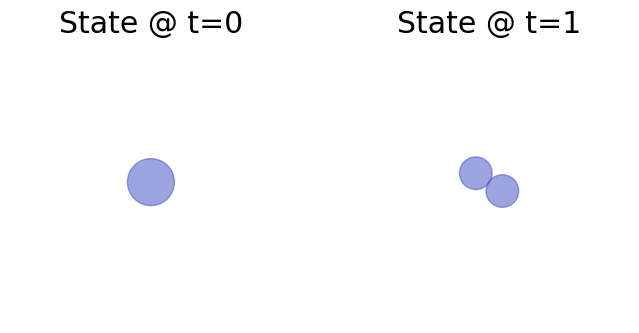

In [7]:
fig, axs = plt.subplots(1,2)

jxm.visualization.draw_circles_ctype(istate, ax=axs[0])
axs[0].set_title('State @ t=0')


jxm.visualization.draw_circles_ctype(new_state, ax=axs[1])
axs[1].set_title('State @ t=1');

# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)

## Simulate trajectory

In [8]:
@eqx.filter_jit
def simulate(model, state, key, n_steps=1, *, history=False):

    subkeys = jax.random.split(key, n_steps)

    def _scan_fn(state, k):
        state, logp = model(state, key=k)
        return state, (state, logp)
    
    state, (trajectory, logp) = jax.lax.scan(_scan_fn, state, np.asarray(subkeys))

    if history:
        return trajectory, logp
    else:
        return state, logp

In [9]:
key, subkey = jax.random.split(key)
fstate, logps = simulate(model, istate, subkey, N_ADD)

In [10]:
logps

Array([ 0.00000000e+00, -1.38629436e+00, -1.68119015e-02, -9.56816979e-06,
       -2.43160857e-02, -1.01840638e+00, -4.90496270e-02, -3.41507422e+00,
       -2.63892733e+00, -2.44747906e+00, -1.24213918e+00, -2.81487422e+00,
       -1.43217247e+00, -2.10167346e+00, -4.58311236e+00, -4.05706029e+00,
       -4.26987595e+00, -4.41148859e+00, -4.31939168e+00, -4.00695610e+00,
       -4.80068615e+00, -5.42610440e+00, -5.40308723e+00, -6.82440640e+00,
       -5.22321855e+00, -5.19785769e+00, -5.15856607e+00, -5.21729833e+00,
       -4.98685868e+00, -5.24130270e+00, -5.30672998e+00, -5.40306052e+00,
       -5.86935670e+00, -6.24286273e+00, -6.16277082e+00, -6.21666180e+00,
       -6.44777837e+00, -6.02484610e+00, -6.52199069e+00, -6.48682664e+00,
       -8.02309191e+00, -6.80959389e+00, -6.85496144e+00, -6.37168111e+00,
       -6.71798663e+00, -6.78456613e+00, -6.70938919e+00, -7.10477085e+00,
       -6.95604874e+00, -6.77798331e+00, -6.97455641e+00, -6.73906156e+00,
       -6.73684578e+00, -

### Visualizations

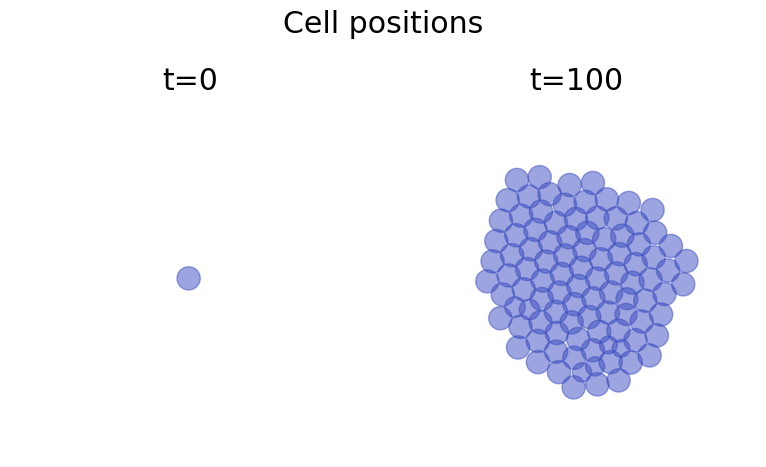

In [11]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Cell positions', y=.8)


jxm.visualization.draw_circles_ctype(istate, ax=axs[0])
axs[0].set_title('t=0')

jxm.visualization.draw_circles_ctype(fstate, ax=axs[1])
axs[1].set_title(f't={N}');


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

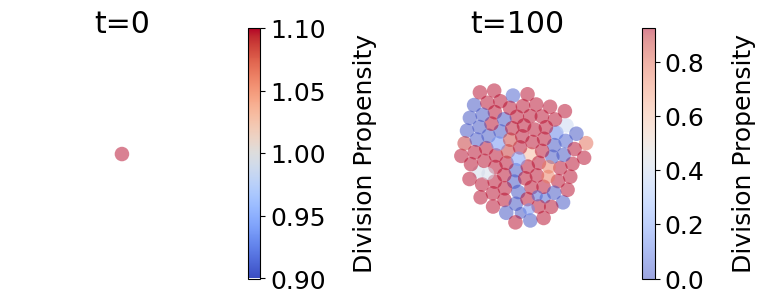

In [12]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_divrate(istate, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_divrate(fstate, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

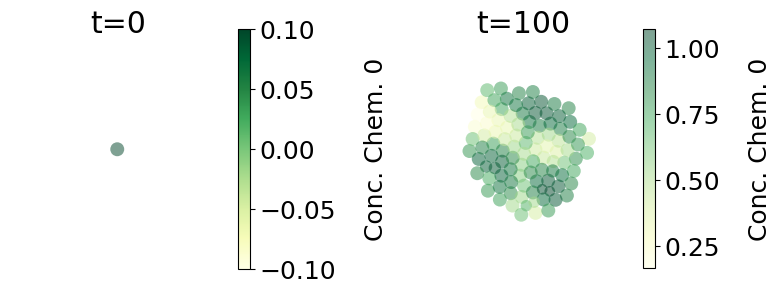

In [20]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_chem(istate, chem=0, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_chem(fstate, chem=0, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

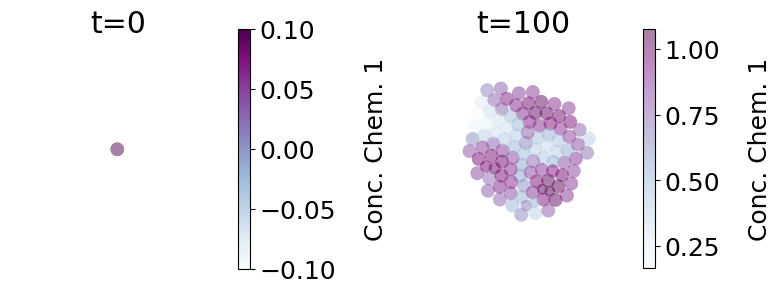

In [21]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_chem(istate, chem=1, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_chem(fstate, chem=1, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

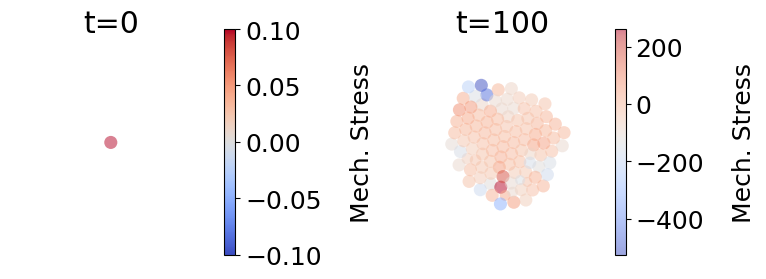

In [22]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_stress(istate, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_stress(fstate, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()